In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [209]:
# https://data.mendeley.com/datasets/8dfh724hvc/1
df = pd.read_csv("./Magnet_CTF_2019_Windows_Desktop_evt.csv")

In [210]:
sum(df["event_id"].isin([41]))

1213

In [211]:
df.columns

Index(['Unnamed: 0', 'inode', 'id', 'datetime', 'computer_name', 'source_name',
       'filename_type', 'filename_security', 'filename_application',
       'filename_system', 'filename_rdp', 'filename_powershell',
       'filename_other', 'recovered', 'user_sid', 'execution_process_id',
       'channel', 'event_id', 'audit_account_logon',
       'audit_account_management', 'audit_detailed_tracking',
       'audit_logon_logoff', 'audit_ds_access', 'audit_object_access',
       'audit_policy_change', 'audit_privilege_usage', 'audit_system', 'task',
       'keywords', 'keywords_audit_failure', 'keywords_audit_success',
       'keywords_correlation_hint', 'keywords_event_log_classic',
       'keywords_sqm', 'keywords_wdi_context', 'keywords_wdi_diagnostic',
       'timestamp', 'epochtime', 'hour', 'minute'],
      dtype='object')

In [212]:
pd.to_datetime(df["datetime"]).diff().sort_values()[-400:]

26359      0 days 00:42:45
23766      0 days 00:42:49
23470      0 days 00:42:49
15516      0 days 00:42:52
19360      0 days 00:42:53
                ...       
14403      0 days 01:01:00
5033       0 days 06:14:44
104399     2 days 01:52:54
9830     153 days 10:05:11
0                      NaT
Name: datetime, Length: 400, dtype: timedelta64[ns]

In [213]:
ind = pd.to_datetime(df["datetime"]).diff().sort_values()[-400:].index[:-1]

In [221]:
df.loc[ind.union(ind - 1)][["id", "datetime", "computer_name", "source_name", "filename_type", "recovered", "event_id"]]

,id,datetime,computer_name,source_name,filename_type,recovered,event_id
5032,9e12560d-db0a-4a10-80a4-49e90153ef5f,2018-07-28 01:09:56,DESKTOP-0QT8017,Microsoft-Windows-Kernel-General,System,0,13
5033,fcff0703-47c6-4170-94a4-c5331368c67f,2018-07-28 07:24:40,WIN-LL0C19JS506,Microsoft-Windows-Kernel-General,System,0,12
9829,c325143a-9792-42b7-a86b-01ab50c10d1e,2018-07-28 08:35:48,DESKTOP-0QT8017,Microsoft-Windows-Kernel-General,System,0,13
9830,e10f5842-b80a-4e8b-81bd-4f0a0d3c623a,2018-12-28 18:40:59,DESKTOP-0QT8017,Microsoft-Windows-Kernel-General,System,0,1
14208,8ae0b185-d1bc-49eb-8bee-1f4d3a75139d,2018-12-29 02:24:33,DESKTOP-0QT8017,Microsoft-Windows-TaskScheduler,Other,0,800
...,...,...,...,...,...,...,...
38062,90402a5f-81e2-4664-bda8-333186cec753,2019-02-25 13:11:33,DESKTOP-0QT8017,Microsoft-Windows-StorPort,Other,0,505
38066,21347f87-f026-4be2-9e80-f99bd582752e,2019-02-25 13:25:58,DESKTOP-0QT8017,Microsoft-Windows-WMI-Activity,Other,0,5857
38067,32b7ee00-4a01-491f-a4ae-a070225abc8c,2019-02-25 14:16:33,DESKTOP-0QT8017,Microsoft-Windows-StorPort,Other,0,505
104398,c598e42c-f44b-4865-825c-fd5f4781027e,2019-03-18 19:02:32,DESKTOP-0QT8017,Microsoft-Windows-Kernel-General,System,0,13


In [222]:
df["Shutdown"] = np.nan
df.loc[sorted(ind), "Shutdown"] = range(len(ind))
df["Shutdown"] = df["Shutdown"].interpolate("bfill")

In [223]:
df["Shutdown"] = df["Shutdown"].fillna(len(ind))
df = df[~df.duplicated(subset=["datetime", "event_id"])]
df = df[df["filename_type"] == "System"]

In [224]:
import networkx as nx
import matplotlib.pyplot as plt

In [225]:
# ! pip install mlxtend

In [226]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import fpmax

In [227]:
transactions = df.groupby("Shutdown").aggregate({"event_id":list}).values[:, 0]

In [331]:
def get_frequent_items(transac, model="apriori"):
    te = TransactionEncoder()
    te_ary = te.fit(transac).transform(transac)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    if model == "apriori":
        return apriori(df, min_support=0.1, max_len=5, use_colnames=True)
    elif model == "fpgrowth":
        return fpgrowth(df, min_support=0.1, max_len=5, use_colnames=True)
    return None

frequent_itemsets = get_frequent_items(transactions, model="fpgrowth")
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.0, num_itemsets=3)

In [332]:
rules.sort_values('lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
393,"(1, 19, 37)","(43, 35)",0.113821,0.121951,0.113821,1.000000,8.2,1.0,0.099941,inf,0.990826,0.933333,1.000000,0.966667
407,"(19, 37)","(1, 35, 43)",0.113821,0.121951,0.113821,1.000000,8.2,1.0,0.099941,inf,0.990826,0.933333,1.000000,0.966667
375,"(19, 37)","(43, 35, 44)",0.113821,0.121951,0.113821,1.000000,8.2,1.0,0.099941,inf,0.990826,0.933333,1.000000,0.966667
373,"(43, 37)","(19, 35, 44)",0.113821,0.121951,0.113821,1.000000,8.2,1.0,0.099941,inf,0.990826,0.933333,1.000000,0.966667
390,"(1, 35, 43)","(19, 37)",0.121951,0.113821,0.113821,0.933333,8.2,1.0,0.099941,13.292683,1.000000,0.933333,0.924771,0.966667
391,"(19, 1, 35)","(43, 37)",0.121951,0.113821,0.113821,0.933333,8.2,1.0,0.099941,13.292683,1.000000,0.933333,0.924771,0.966667
392,"(1, 43, 37)","(19, 35)",0.113821,0.121951,0.113821,1.000000,8.2,1.0,0.099941,inf,0.990826,0.933333,1.000000,0.966667
277,"(43, 37)","(19, 35)",0.113821,0.121951,0.113821,1.000000,8.2,1.0,0.099941,inf,0.990826,0.933333,1.000000,0.966667
275,"(19, 37)","(43, 35)",0.113821,0.121951,0.113821,1.000000,8.2,1.0,0.099941,inf,0.990826,0.933333,1.000000,0.966667
274,"(43, 35)","(19, 37)",0.121951,0.113821,0.113821,0.933333,8.2,1.0,0.099941,13.292683,1.000000,0.933333,0.924771,0.966667


In [333]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(43),(44),0.455285,0.512195,0.455285,1.000000,1.952381,1.0,0.222090,inf,0.895522,0.888889,1.000000,0.944444
1,(44),(43),0.512195,0.455285,0.455285,0.888889,1.952381,1.0,0.222090,4.902439,1.000000,0.888889,0.796020,0.944444
2,(19),(43),0.455285,0.455285,0.455285,1.000000,2.196429,1.0,0.248001,inf,1.000000,1.000000,1.000000,1.000000
3,(43),(19),0.455285,0.455285,0.455285,1.000000,2.196429,1.0,0.248001,inf,1.000000,1.000000,1.000000,1.000000
4,(19),(44),0.455285,0.512195,0.455285,1.000000,1.952381,1.0,0.222090,inf,0.895522,0.888889,1.000000,0.944444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,(1),"(19, 43, 44, 37)",0.341463,0.113821,0.113821,0.333333,2.928571,1.0,0.074955,1.329268,1.000000,0.333333,0.247706,0.666667
696,(37),"(19, 1, 43, 44)",0.308943,0.138211,0.113821,0.368421,2.665635,1.0,0.071122,1.364499,0.904202,0.341463,0.267130,0.595975
697,(43),"(1, 19, 44, 37)",0.455285,0.113821,0.113821,0.250000,2.196429,1.0,0.062000,1.181572,1.000000,0.250000,0.153670,0.625000
698,(44),"(19, 1, 43, 37)",0.512195,0.113821,0.113821,0.222222,1.952381,1.0,0.055523,1.139373,1.000000,0.222222,0.122324,0.611111


In [285]:
model = apriori(df, min_support=0.001, max_len=2, use_colnames=True)
rules = association_rules(model, metric="support", min_threshold=0.0, num_itemsets=3)
r = rules[["antecedents", "consequents", "confidence", "antecedent support"]]
r["antecedents"] = r["antecedents"].apply(lambda x: list(x)[0])
r["consequents"] = r["consequents"].apply(lambda x: list(x)[0])

support_dict = r.set_index("antecedents")["antecedent support"].to_dict()

def get_confidence(a, c):
    # rules[["antecedents", "consequents", "confidence"]]
    r_ = r.query(f"(antecedents == {a}) and (consequents == {c})")
    if r_.shape[0] == 1:
        return r_["confidence"].iloc[0]
    return 0.0

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_7636\1239064787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r["antecedents"] = r["antecedents"].apply(lambda x: list(x)[0])
C:\Users\vasiliev\AppData\Local\Temp\ipykernel_7636\1239064787.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r["consequents"] = r["consequents"].apply(lambda x: list(x)[0])


In [232]:
# apriori_model = get_frequent_items(transactions, model='apriori')
# apriori_rules = association_rules(apriori_model, metric="confidence", min_threshold=0.3)

In [308]:
G=nx.MultiDiGraph()
for t in transactions:
    for i in range(len(t) - 1):
        G.add_node(t[i], weight=support_dict.get(t[i], 0.0))
        G.add_edge(t[i], t[i+1]) # , weight=get_confidence(t[i], t[i+1]))

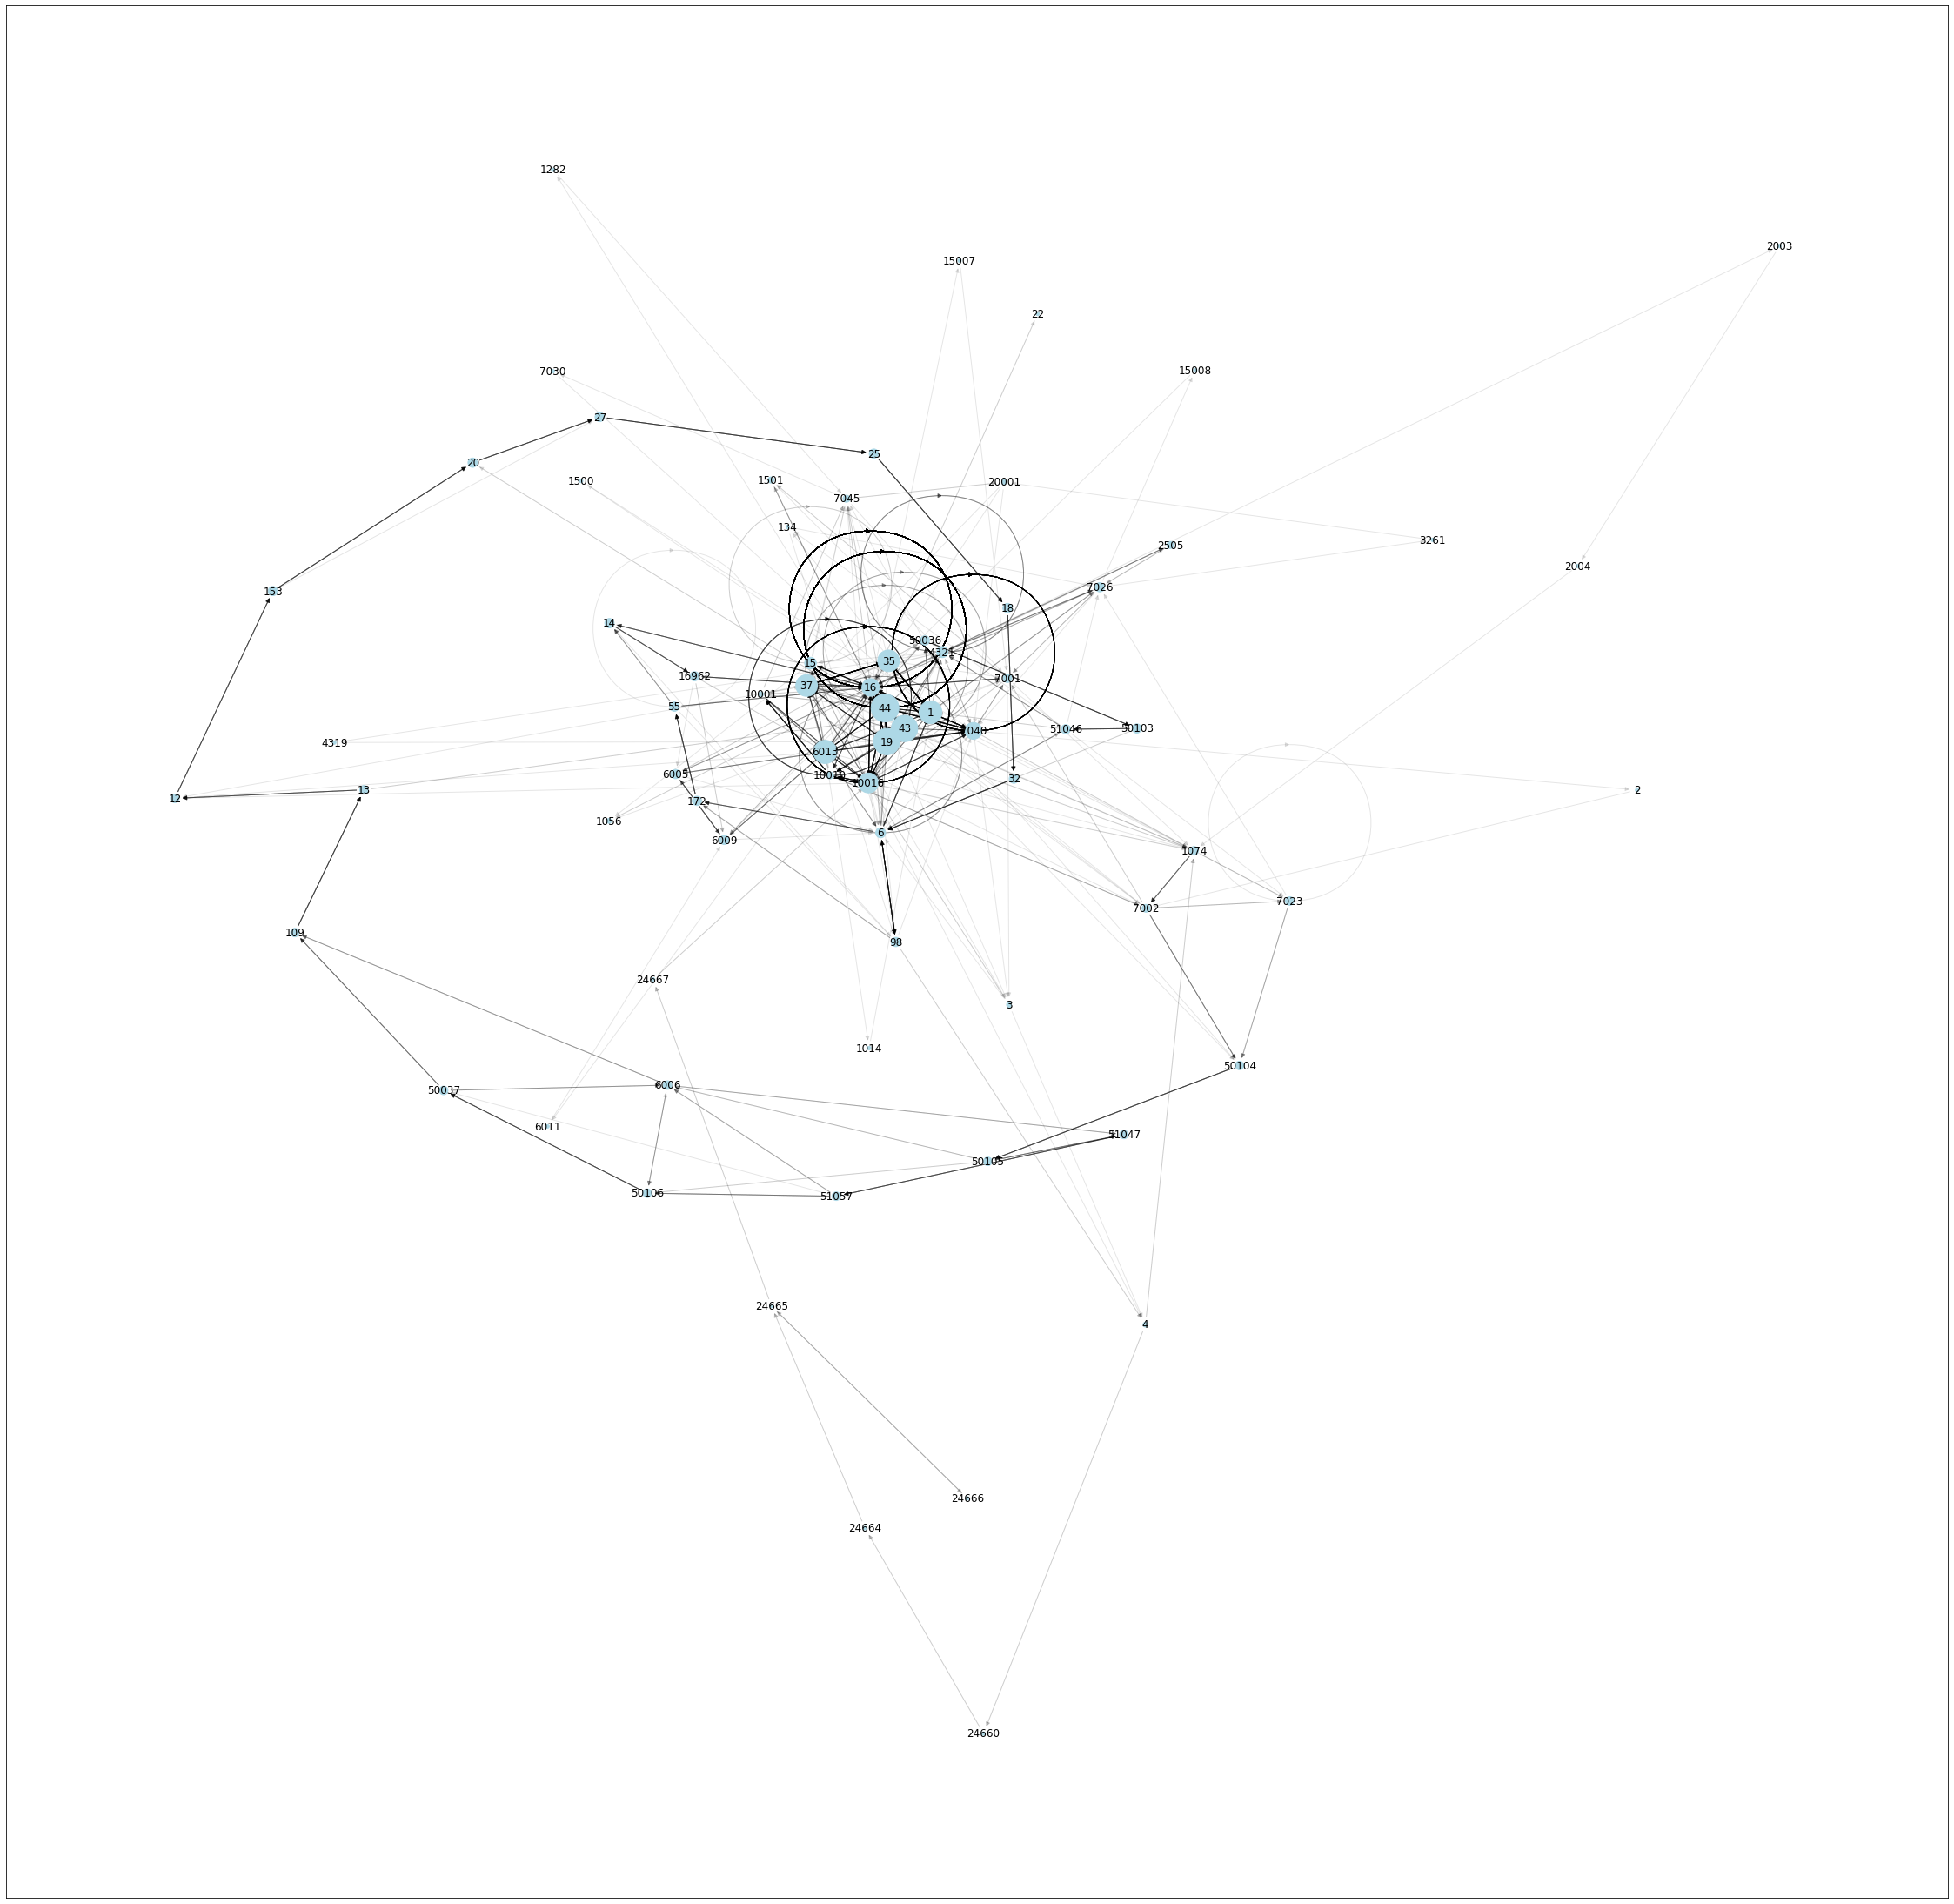

In [334]:
plt.figure(figsize=(40, 40))
# pos = nx.spring_layout(G)
# nodes = nx.draw_networkx_nodes(G, pos)
# edges = nx.draw_networkx_edges(G, pos, alpha=0.2)
# labels = nx.draw_networkx_labels(G, pos)

pos = nx.spring_layout(G)
# Получение весов вершин и ребер
node_weights = [G.nodes[node]['weight'] for node in G.nodes()]
# Настраиваем цвета и размеры для вершин и ребер
node_sizes = np.array(node_weights) * 2000  # Умножаем на константу для визуального эффекта

# Рисование графа
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue')
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos);

In [313]:
closeness = nx.closeness_centrality(G)
sorted(closeness.items(), key=lambda x: x[1])

[(32, 0.14228456913827656),
 (24666, 0.14285714285714285),
 (24667, 0.1440162271805274),
 (13, 0.15883668903803133),
 (18, 0.16359447004608296),
 (24665, 0.16627634660421545),
 (51057, 0.1834625322997416),
 (50037, 0.18489583333333334),
 (109, 0.18635170603674542),
 (25, 0.19241192411924118),
 (24664, 0.19346049046321526),
 (51047, 0.22327044025157233),
 (50106, 0.22397476340694006),
 (6006, 0.22468354430379747),
 (55, 0.2253968253968254),
 (27, 0.23355263157894737),
 (24660, 0.23588039867109634),
 (50103, 0.23986486486486486),
 (2004, 0.24232081911262798),
 (7030, 0.24315068493150685),
 (15008, 0.24567474048442905),
 (3261, 0.2465277777777778),
 (20001, 0.24912280701754386),
 (153, 0.24912280701754386),
 (50105, 0.2600732600732601),
 (1500, 0.2720306513409962),
 (1014, 0.27307692307692305),
 (134, 0.27413127413127414),
 (4319, 0.27734375),
 (7023, 0.2784313725490196),
 (2505, 0.2795275590551181),
 (20, 0.28174603174603174),
 (1056, 0.285140562248996),
 (51046, 0.285140562248996),
 (17

In [314]:
betweenness = nx.betweenness_centrality(G)
sorted(betweenness.items(), key=lambda x: x[1])

[(15008, 0.0),
 (15007, 0.0),
 (22, 0.0),
 (6011, 0.0),
 (134, 0.0),
 (1500, 0.0),
 (2505, 0.0),
 (24666, 0.0),
 (4319, 0.00010563380281690141),
 (2, 0.00022971160295103956),
 (1014, 0.0003890006706908115),
 (1056, 0.0004609475032010243),
 (1501, 0.0005935613682092556),
 (1282, 0.0008440754416609546),
 (16962, 0.0008911159263271938),
 (7030, 0.0011697377245931731),
 (14, 0.0016447167855618559),
 (3261, 0.001683820873961719),
 (10001, 0.0020474830333985267),
 (6005, 0.0024767407865999417),
 (35, 0.0038951814593279474),
 (3, 0.010736891427505703),
 (7023, 0.011241454328210157),
 (50106, 0.013682092555331992),
 (51047, 0.014084507042253521),
 (51057, 0.014084507042253521),
 (172, 0.014084507042253521),
 (55, 0.014084507042253521),
 (50036, 0.014084507042253521),
 (50103, 0.014084507042253521),
 (2003, 0.014084507042253521),
 (2004, 0.014084507042253521),
 (20001, 0.014285714285714285),
 (15, 0.014692128796756562),
 (51046, 0.0149674494867713),
 (6009, 0.016561247828853463),
 (19, 0.019311